In [1]:
# Importing the required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import cv2
from random import randint
from IPython.display import SVG
import matplotlib.gridspec as gridspec
import PIL
from PIL import Image
import random
import matplotlib.image as mpimg
import keras
import glob

%matplotlib inline

In [2]:
# Importing the required libraries

from os import listdir
from os.path import join

In [3]:
# Importing the required libraries

from os import listdir
from numpy import array
from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from tensorflow.keras.utils import to_categorical
from keras.layers import Embedding, TimeDistributed, RepeatVector, LSTM, concatenate , Input, Reshape, Dense, Flatten, GRU, Bidirectional, Dropout
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.applications.densenet import DenseNet201, preprocess_input
import numpy as np

In [4]:
# Load the images and preprocess them for Densenet201

images = []
files = listdir('/content/drive/MyDrive/dataset_new1.3/gui/')
files.sort()
for filename in files:
    images.append(img_to_array(load_img('/content/drive/MyDrive/dataset_new1.3/gui/'+filename, target_size=(299, 299))))
images = np.array(images, dtype=float)
images = preprocess_input(images)

In [5]:
# Run the images through DenseNet201 model
densenet = DenseNet201(weights='imagenet', include_top=False)
ext_features = densenet.predict(images)

74850304/74836368 [==============================] - 1s 0us/step


In [6]:
# Printing the extracted feature shapes 

ext_features.shape

(2, 9, 9, 1920)

In [8]:
# This piece of code is referred from the website "https://www.programmersought.com/article/3918650197/"


maximum_caption_length = 100
token = Tokenizer(filters='', split=" ", lower=False)

# Function to read the document
def read_file(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

# Loading the HTML files
X = []
all_files = listdir('/content/drive/MyDrive/dataset_new1.3/html/')
all_files.sort()
for filename in all_files:
    X.append(read_file('/content/drive/MyDrive/dataset_new1.3/html/'+filename))

# Creating the vocabulary from html files
token.fit_on_texts(X)

# Add +1 to leave space for empty words
vocab_size = len(token.word_index) + 1

sequences = token.texts_to_sequences(X)
max_length = max(len(s) for s in sequences)

X, y, image_data = list(), list(), list()
for img_no, seq in enumerate(sequences):
    for i in range(1, len(seq)):
        in_seq, out_seq = seq[:i], seq[i]
        # Padding the sentences, if the sentence is short
        in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
        out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
        image_data.append(ext_features[img_no])
        X.append(in_seq[-100:])
        y.append(out_seq)

X, y, image_data = np.array(X), np.array(y), np.array(image_data)

In [10]:
# Building the model
# Importing the regularizers
from keras.regularizers import l2, l1

# Create the encoder
image = Input(shape=(9, 9, 1920,))
image_flatten = Flatten()(image)
image_flatten = Dense(128, activation='relu')(image_flatten)
rep_vec = RepeatVector(maximum_caption_length)(image_flatten)

language_input = Input(shape=(maximum_caption_length,))
language = Embedding(vocab_size, 200, input_length=maximum_caption_length)(language_input)
language = Bidirectional(LSTM(64, kernel_regularizer = l2(0.01), return_sequences=True))(language)
language = Dropout(0.3)(language)
language = Bidirectional(LSTM(64, kernel_regularizer = l2(0.01), return_sequences = True))(language)
language = Dropout(0.3)(language)
language = Bidirectional(LSTM(64, return_sequences=True))(language)
language = TimeDistributed(Dense(32, activation='relu'))(language)

# Create the decoder
decoder = concatenate([rep_vec, language])
decoder = Bidirectional(LSTM(64, kernel_regularizer = l2(0.01), return_sequences=False))(decoder)
decoder_output = Dense(vocab_size, activation='softmax')(decoder)

In [12]:
# Compile the model
import tensorflow 
from tensorflow.keras.optimizers import Adam

model = Model(inputs=[image, language_input], outputs=decoder_output)
model.compile(loss='categorical_crossentropy', optimizer=tensorflow.keras.optimizers.Adam(lr = 0.001, decay = 0.001))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [14]:
# Train the neural network
history = model.fit([image_data, X], y, batch_size=64, shuffle=False, epochs=150, validation_split = 0.2)

Epoch 1/150
103/103 [==============================] - 114s 1s/step - loss: 10.3435 - val_loss: 7.9447
Epoch 2/150
103/103 [==============================] - 112s 1s/step - loss: 7.3759 - val_loss: 6.6738
Epoch 3/150
103/103 [==============================] - 112s 1s/step - loss: 7.2764 - val_loss: 6.5172
Epoch 4/150
103/103 [==============================] - 113s 1s/step - loss: 7.0889 - val_loss: 6.0297
Epoch 5/150
103/103 [==============================] - 113s 1s/step - loss: 6.9111 - val_loss: 6.0045
Epoch 6/150
103/103 [==============================] - 113s 1s/step - loss: 6.9169 - val_loss: 6.0794
Epoch 7/150
103/103 [==============================] - 113s 1s/step - loss: 6.8600 - val_loss: 6.1524
Epoch 8/150
103/103 [==============================] - 114s 1s/step - loss: 6.8232 - val_loss: 5.9418
Epoch 9/150
103/103 [==============================] - 114s 1s/step - loss: 6.8069 - val_loss: 6.0442
Epoch 10/150
103/103 [==============================] - 113s 1s/step - loss: 6.77

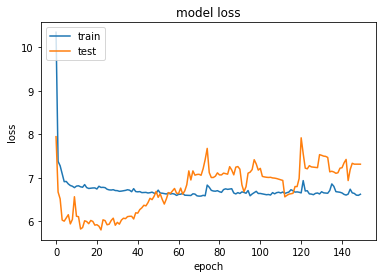

In [15]:
# Visualizing the loss (using l2 regularizer)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

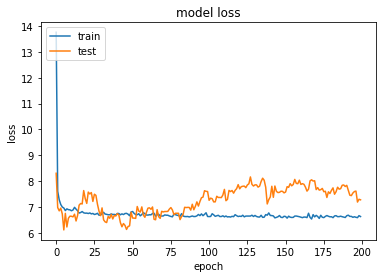

In [ ]:
# Visualizing the loss (using l1 regularizer)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [16]:
# This piece of code is referred from the website "https://www.programmersought.com/article/3918650197/"
# map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [21]:
# This piece of code is referred from the website "https://www.programmersought.com/article/3918650197/"

# generate a description for an image
def description(model, tokenizer, photo, maximum_length):
    in_text = 'START'
    for i in range(900):
        seq = tokenizer.texts_to_sequences([in_text])[0][-100:]
        seq = pad_sequences([seq], maxlen=maximum_length)
        yhat = model.predict([photo,seq], verbose=0)
        yhat = np.argmax(yhat)
        word = word_for_id(yhat, tokenizer)
        
        if word is None:
            break
        in_text += ' ' + word
        print(' ' + word, end='')
        if word == 'END':
            break
    return

In [23]:
# Testing
test = img_to_array(load_img('/content/drive/MyDrive/HTML/images/88.jpg', target_size=(299, 299)))
test = np.array(test, dtype=float)
test = preprocess_input(test)
test_features = densenet.predict(np.array([test]))
description(model, token, np.array(test_features), 100)

 , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , , ,

In [24]:
# Saving the trained model

from keras.models import model_from_json

model_json = model.to_json()
with open("model_densenet.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_densenet.h5")
print("Saved model to disk")

Saved model to disk
